In [1]:
from __future__ import unicode_literals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import json
import gzip
import spacy
import textacy
%matplotlib inline
np.random.seed(32113)
import pickle
from sklearn.decomposition import NMF
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF
from nltk.corpus import stopwords
from spacy.en import English
import string
parser = English()
import data_prep as dp
import math

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


---------------------------

## Loading data

In [2]:
# loading reviews and meta data
path = './data/reviews_Home_and_Kitchen.json.gz'
meta_path = './data/meta_Home_and_Kitchen.json.gz'

### Before creating  a model:
In order to create an accurate model, we want to filter reviews.  
we filter review by looking at categories of product in meta data. 
  
Below are codes to check products associated with review data.
It displays types of categories and number of 'Home & Kitchen' products that are associated with each category.  
As you can see, there are many 'Home & kitchen' products  
that are associated with categories that are unrelated to Home & Kitchen. 
By looking at this list, we can decide how to filter products.  
  
In this case, I would filter out categories where total number is less than 2000.  
If you want to strictly work on Home & kitchen products, I will filter out categories less than 10000.  

Once we merge review data and meta data, we will filter out reviews by these categories.

In [5]:
#run this code if you do not know if products belong to unrelated categories
df_test = dp.Data_prep1(path)
meta = dp.getDF(meta_path)
meta = dp.add_meta_info(df_test,meta,'Home & Kitchen',20,True)

                             asin  salesRank   imUrl  categories   title  \
rank_keys                                                                  
Appliances                     68         68      68          68      68   
Arts, Crafts & Sewing        1776       1776    1776        1776    1776   
Automotive                     38         38      38          38      11   
Baby                          153        153     153         153     153   
Beauty                        604        604     604         604     604   
Books                           1          1       1           1       1   
Camera &amp; Photo             60         60      60          60      60   
Cell Phones & Accessories       8          8       8           8       8   
Clothing                     1489       1489    1489        1489    1489   
Computers & Accessories        12         12      12          12      12   
Electronics                   671        671     671         671     671   
Grocery & Go

------------

## Preparing train and test data

### Merging data, Cleaning Meta data  
the function **df_prep1** will do three things for you:  
1. Cleaning meta data for you (gets rid of Nan values)  
2. Add features created from Meta data (categories, sales ranking within the categories and price)   
3. Filter out categories that are not associated with the data topics  
4. Merge meta data with review datas and output pandas dataframe 
5. reassign values of 'helpful' features into 2 values and calculate percentage of positive votes on a review.  
  
inputs:  
**dp.df_prep1( a , b , c , d )**  
a = path of your review data (json.gz format)  
b = path of your meta data (json.gz format)  
c = topic keys: category names that every product in your dataset is associated with.  
for example: 'Video Games', 'Home &amp; Kitchen' etc.  
d = filtering out categoiry if the total number of product associated with that category is less than this number.  

In [7]:
df= dp.df_prep1(path, meta_path,'Home & Kitchen',5000)
# should spit out average price for each category.  
# these price will be filling Nan under price feature

average price for Home &amp; Kitchen is $129.110169121


data_prep_new.py:493: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_topic['price'] = df_topic['price'].fillna(average_val)


average price for Home & Kitchen is $132.971979089
average price for Kitchen & Dining is $77.4992568967
--- 857.797745943 seconds ---


In [8]:
print len(df)

81775


### Split train and test dataset:
In NLP prediction model, it is safe to run train and test dataset before running model building functions.  
Here, we are randomly selecting 85% of data as a train dataset.  
and assign rest of the data as test dataset.  

In [9]:
ind = df.index
random_ind = np.random.choice(list(ind), int(len(df)*.85), replace=False)
df_train = df.loc[list(random_ind)]
test_ind = [i for i in ind if i not in random_ind]
df_test = df.loc[test_ind]


In [13]:
## if you want to save test and training dataframe...
# df_test.to_pickle("./HomeandKitchen_df_test_15percent.pkl")
# df_train.to_pickle("./HomeandKitchen_df_train_85percent.pkl")

### tfidf model
**df_prep_train1** function creates tfidf matrix and tfidf sklearn model.  
It also saves tfidf matrix and tfidf skearn model as a pickle file in case something happens later.  
  
inputs:
**df_prep_train1( a , b , c(optional) )**  
a = your training dataframe created above  
b = filename/keyword. this string will be used to name tfidf matrix and tfidf sklearn model pickle file.  
c = a list containing parameters of TfidfVectorizer sklearn class. this is optional.  
default values for this input is:  tfidf_set = [2,0.95,10000,'l2']  
  
where TfidfVectorizer(stop_words=STOPLIST, tokenizer=lemma, min_df=tfidf_set[0], max_df=tfidf_set[1], max_features =tfidf_set[2], norm=tfidf_set[3])  
  
visit Sklearn web for more details.     
http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [10]:
tfidf_matrix, tfidf_model  = dp.df_prep_train1(df_train,'HomeAndKitchen')

--- 695.414065123 seconds ---


### before running NMF, check your elbow!
the function **NMF_elbow** will give you stats about reconstruction error for different K component.  
you want to chose right K where slope changes significantly.  
Since the data we are using does not have obvious elbow,  
I added error difference between K and error of each K.  

inputs:  
**NMF_elbow( a , b )**  
a = your tfidf matrix  
b = range of K (list)  

calculated in 162.172966003 seconds 


error difference
1.07929379637
0.858621313474
0.789527637731
0.815067794558
0.658543930188
0.595061152613
0.562621833959
0.550520568273
0.527111543583
0.446938722788


error k = 1: 259.161844291
error k = 2: 258.082550495
error k = 3: 257.223929181
error k = 4: 256.434401544
error k = 5: 255.619333749
error k = 6: 254.960789819
error k = 7: 254.365728666
error k = 8: 253.803106832
error k = 9: 253.252586264
error k = 10: 252.72547472
error k = 11: 252.278535998


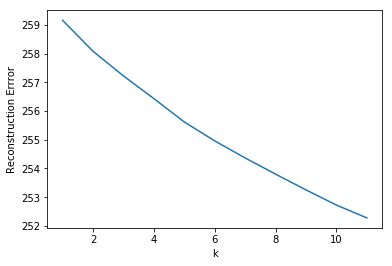

In [11]:
dp.NMF_elbow(tfidf_matrix, range(1,12))

### Adding NMF results and tfidf results onto training dataset
**df_prep_train2** function does lots of things here.
1. calculate NMF from the tfidf matrix that you created from df_prep_train1
2. add NMF results as features (predict percentage values for each NMF topics)
3. print outs top 20 words that are highly associated with each NMF topics.
4. add tfidf results to training dataset  
(you can select how many words you want to add to the data frame by choosing values for max_feat (e))  
5. saves resulting training dataframe, NMF model and tfidf feature model as pickle files

inputs:  
**df_prep_train2**( a , b , c , d , e (opt) , f (opt), g (opt))  
a = training dataframe.  
b = filename/keyword. this string will be used to name NMF model and tfidf feature model pickle file.  
c = tfidf matrix.
d = tfidf model.  
e = max feature (optional). default value = 1000. 
will create tfidf model with top 1000 (default) words   
and create features of these top 1000 words in your training dataframe.  
f = NMF parameters (optional). default values NMF_set = [6,'cd',0.1,0.5].  
where NMF(n_components=NMF_set[0], solver=NMF_set[1], random_state=32113, alpha=NMF_set[2], l1_ratio=NMF_set[3])  
visit Sklearn web for more details.  
http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html  

g = tfidf parameters (optional). default values = [2,0.95,10000,'l2'].  
  
where TfidfVectorizer(stop_words=STOPLIST, tokenizer=lemma, min_df=tfidf_set[0], max_df=tfidf_set[1], max_features =tfidf_set[2], norm=tfidf_set[3])  
visit Sklearn web for more details.  
http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html  
(3rd value will be replaced by max feature (e))  

In [4]:
df_train_new,NMF_model,TFIDF_feat_model = dp.df_prep_train2(df_train, 'HomeAndKitchen', tfidf_matrix, tfidf_model,1000, [10,'cd',0.1,0.5])

Topic #0:
machine blender ice use make juicer juice cream bowl mixer clean blade easy food bread time fruit smoothie good dough
Topic #1:
coffee cup water maker machine brew filter grind carafe grinder espresso hot ground pot make bean use pour mug taste
Topic #2:
vacuum carpet floor clean dyson dirt bag suction hair brush dust cleaner attachment hose use canister pick hoover vac filter
Topic #3:
knife blade sharp set sharpen cut edge chef sharpener handle slice steel block use henckel wusthof good steak hand dull
Topic #4:
pan stick cook non use heat cookware pot egg set oil iron food grill handle cast skillet clean surface calphalon
Topic #5:
mattress bed pillow sleep sheet foam memory pad night topper soft comfortable feel firm cover like smell queen wake good
Topic #6:
rice cooker cook pot pressure slow brown cooking steam cup water lid time use warm crock food make steamer minute
Topic #7:
unit fan air room water heater filter heat cool run window temperature work low turn quiet u

In [10]:
# in case you need to load each model, you can load models here

## df_prep1/train-test split result
#df_train = pd.read_pickle('./HomeandKitchen_df_train_85percent.pkl')
#df_test = pd.read_pickle('./HomeandKitchen_df_test_15percent.pkl')

# df_prep_train1 results
# with open(r"HomeAndKitchen_tfidf_matrix.pickle", "rb") as input_file:
#    tfidf_matrix = pickle.load(input_file)
# with open(r"HomeAndKitchen_tfidf_model.pickle", "rb") as input_file:
#    tfidf_model= pickle.load(input_file)

# df_prep_train2 results
df_train_new = pd.read_pickle('./preped_HomeAndKitchen_max_feature1000.pkl')
# with open('HomeAndKitchen_NMF_model.pickle', "rb") as input_file:
#     NMF_model = pickle.load(input_file)
# with open(r"HomeAndKitchen_tfidf_feat_model.pickle", "rb") as input_file:
#     TFIDF_feat_model= pickle.load(input_file)
df_test_new = pd.read_pickle('./preped_HomeAndKitchen_df_test.pkl')

### Preparing test dataset

Now we want to prepare test dataset.  
I simply used MNF and tfidf models of training dataset to transform test dataset.  


**df_prep_test** function adds features for test data.  
It uses transform method of NMF and tfidf models that we just trained with training dataset.  
The function outputs test dataframe which contains same amount of features as training dataframe.  
It also saves output dataframe as a pickle file.  

inputs:  
**df_prep_test**( a , b , c , d , e )  
a = test dataframe we created previously. (read Split train and test dataset section above)  
b = tfidf model trained with training dataframe.  
c = NMF model that was trained with training dataframe.
d = second tfidf model that is used to create tfidf term features.  
e = filename/keywords used as a name of pickle file.  

In [8]:
df_test_new = dp.df_prep_test(df_test, tfidf_model,NMF_model, TFIDF_feat_model, 'HomeAndKitchen')

--- 123.56338501 seconds ---


-----------------

## making XGboost model

### preparing labels for prediction modeling
Before running prediction model with XGboost, we want to create labels for our model. 
For this prediction model, I created a feature called 'helpful_percent'  
which indicates percentage of user voted review as helpful review.
I want to split this feature into two groups to make my prediction model binary classifier.

the function **label_prep** is a function that prepares label feature.
It also prints out total number of reviews that belongs LOW and HIGH label class in your data frame.  

input:
**dp.label_prep( a , b )**
a = train or test dataframe.  
b = float value that splits label.  
the label feature has value HIGH or LOW.  
If the 'helpful_precent' is higher than the value of b, label == HIGH.  
If the 'helpful_precent' is lower than the value of b, label == LOW.  
I usually set this values around 0.75 to 0.9.  
What I care most here is predicting HIGH correctly.

In [14]:
#df = pd.read_pickle("./preped_videogame_1000_df.pkl")
print "training data:  "
df_train_new = dp.label_prep(df_train_new, 0.80)

training data:  
highly helpful count: 56322
not helpful count: 13186


In [15]:
print "test data: "
df_test_new = dp.label_prep(df_test_new,0.80)

test data: 
highly helpful count: 9916
not helpful count: 2351


### adjusting number of data in training and test sets
Another step you want to apply before applying XGboost.
Since training and test dataframe most likely have unbalanced label classes (HIGH and LOW),  
we want to balance label classes by randomly select set numbers of reviews from each class.  
From the print statement of previous step (label_prep), you know how many reviews exist in both HIGH and LOW label class.  
Select a number so that the number of reviews for HIGH and LOW are about same.  
  
For example:  
if label_prep prints out:
  
highly helpful count: 34290  
not helpful count: 25345  

I would select number 25000 (if you really want to increase number of reviews, 27500?).  
  
input:  
**df_for_XGBOOST**( a , b )  
a = dataframe  
b = maximum number of reviews in each label class.  

In [16]:
train_X, train_y, df_new_train = dp.df_for_XGBOOST(df_train_new,13000)
test_X, test_y, df_new_test = dp.df_for_XGBOOST(df_test_new,2100)

### XGboost model
function **XGBOOSTING** creates XGboost model, fits training dataset and prints out test data accuracy score.

inputs:
**XGBOOSTING(train_X,test_X,train_y,test_y,xgb_para=[4000,0.15])**
a = X train  
b = X test  
c = label train  
d = label test  
e = parameters for XGboost. xgb_para = [4000,0.15]  
where xgb = XGB.XGBClassifier(n_estimators=xgb_para[0], learning_rate=xgb_para[1])  

In [ ]:
model = dp.XGBOOSTING(train_X,test_X,train_y,test_y,xgb_para=[4000,0.12])

### XGboost stats (Important Features and confusion matrix)
following function prints out Top15 important features of the prediction model,  
confusion matrix that is in the markdown format table,  
LOW prediction rate and HIGH prediction rate.  

input:  
**xgb_stats**( a , b , c , d )  
a = XGboost model  
b = dataframe (an output of df_for_XGBOOST function)  
c = test X data  
d = test label data  

In [21]:
dp.xgb_stats(model,df_new_test,test_X,test_y)

 **TOP15 Important Features**  
percent_GROUP_6 : 0.768120866269%  
place : 0.77660838142%  
watch : 0.895433686674%  
use : 0.950602628291%  
percent_GROUP_2 : 1.10337799415%  
percent_GROUP_5 : 1.19674075395%  
firm : 1.23493466526%  
percent_GROUP_3 : 1.32829742506%  
percent_GROUP_8 : 1.90120525658%  
overall : 1.9903242588%  
percent_GROUP_1 : 2.1940248087%  
price : 2.88151409477%  
percent_GROUP_10 : 2.93243937194%  
rank_values : 3.01731452346%  
text_length : 3.08945849538%  


 |                 |       TRUE LOW       |        TRUE HIGH        |
     |:--------------: | :-------------------:|:-----------------------:|
     |       PRED LOW     |        1746.0        |           854.0        |
     |       PRED HIGH     |        354.0        |           1246.0        |

LOW prediction rate: 83.14%
HIGH prediction rate: 59.33%



----------


## Results Example

Home & Kitchen  
XGBOOST [4000 0.1]  
--- 1143.45797396 seconds ---  
score: 71.45%  

 **TOP15 Important Features**  
percent_GROUP_6 : 0.773677928373%  
percent_GROUP_9 : 0.82894070074%  
use : 0.845944602042%  
watch : 0.884203333408%  
percent_GROUP_2 : 1.03723853827%  
percent_GROUP_5 : 1.06699541211%  
firm : 1.21152866632%  
percent_GROUP_3 : 1.34330894798%  
percent_GROUP_8 : 1.77265778184%  
overall : 2.15524565428%  
percent_GROUP_1 : 2.18075159937%  
price : 2.80139427632%  
text_length : 2.9034178704%  
rank_values : 2.91191972792%  
percent_GROUP_10 : 2.91191972792%  


 |                 |       TRUE LOW       |        TRUE HIGH        |  
     |:--------------: | :-------------------:|:-----------------------:|  
     |       PRED LOW     |        1753.0        |           852.0        |  
     |       PRED HIGH     |        347.0        |           1248.0        |  

LOW prediction rate: 83.48%  
HIGH prediction rate: 59.43%  